## Đánh giá và tối ưu hoá mô hình 

- Lựa chọn các giá trị của các tham số bằng các thửu nghiệm. 
- Với mỗi bộ tham số: 
    - Sử dụng phương pháp cross-validate chia dữ liệu và training, để đánh giá mô hình một cách tổng quát. 
- Sử dụng độ đo Accuracy để làm độ đo đánh giá chất lượng mô hình. 
- Với mỗi mô hình, tìm ra bộ tham số tốt nhất, và tiếp tục thử các mô hình khác. 
- So sánh các mô hình 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve

from sklearn.datasets.base import load_files
from pyvi import ViTokenizer


from sklearn import svm
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.datasets.base import load_files
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline

## Load dữ liệu từ thư mục đã crappy từ trước 

Cấu trúc thư mục như sau 

- data_sample/news_1135/

    - Kinh tế: 
        - bài báo 1.txt 
        - bài báo 2.txt 
    - Pháp luật
        - bài báo 3.txt 
        - bài báo 4.txt 

In [7]:
data_train = load_files(container_path="data_sample/news_1135/", encoding="utf-8")

print(data_train.filenames)
print()

print("Tong so file: {}" .format( len(data_train.filenames)))




['data_sample/news_1135/Tin khác/0218e1df21ce358b9c6485176a48f1fcaeedef67.txt'
 'data_sample/news_1135/Khoa học - Công nghệ/bf9889f5f2ffd6c92fa877d35ef0ef5f34f0666d.txt'
 'data_sample/news_1135/Tin khác/d74aab054ffe9f8661df13bc52b438b48a63fe48.txt'
 ...
 'data_sample/news_1135/Thời sự/a06c1ec4c146d3b4eb5070a1967e10e5e21bdc5b.txt'
 'data_sample/news_1135/Sức khỏe/4187c4a1d528fd9ea4630d2709229df0b0d09c3d.txt'
 'data_sample/news_1135/Thể thao/7adaf0c561796f2411340150f18417543ad4403c.txt']

Tong so file: 1135


## Tiền xử lý dữ liệu đưa dữ liệu từ dạng text về dạng ma trận 

- Thử nghiệm để kiểm tra hoạt động chuyển hoá dữ liệu về dạng ma trận 

In [13]:
# load dữ liệu các stopwords 
with open("vietnamese-stopwords.txt") as f:
    stopwords = f.readlines()
stopwords = [x.strip().replace(" ", "_") for x in stopwords] 
print(stopwords[:10])

# 
# Transforming data 
# Chuyển hoá dữ liệu text về dạng vector tfidf 
#     - loại bỏ từ dừng
#     - sinh từ điển
module_count_vector = CountVectorizer(stop_words=stopwords)
model_rf_preprocess = Pipeline([('vect', module_count_vector),
                    ('tfidf', TfidfTransformer()),
                    ])
# Hàm thực hiện chuyển đổi dữ liệu text thành dữ liệu số dạng ma trận 
# Input: Dữ liệu 2 chiều dạng numpy.array, mảng nhãn id dạng numpy.array 
data_preprocessed = model_rf_preprocess.fit_transform(data_train.data, data_train.target)
print(module_count_vector.vocabulary_)



['a_lô', 'a_ha', 'ai', 'ai_ai', 'ai_nấy', 'ai_đó', 'alô', 'amen', 'anh', 'anh_ấy']
{'dân_trí': 6928, 'sở': 17869, 'gd': 7729, 'đt': 23214, 'tỉnh': 20851, 'gia_lai': 7816, 'văn_bản': 21779, '2258': 858, 'sgdđt': 17039, 'vp': 21572, 'chấn_chỉnh': 4971, 'tiếp_thị': 19345, 'sách': 17584, 'vật_dụng': 21910, 'cơ_sở': 5986, 'giáo_dục': 7955, 'chỉ_đạo': 5092, 'tuyệt_đối': 20254, 'phép': 15402, 'tập_thể': 20796, 'trường': 19928, 'quảng_cáo': 16194, 'mua_bán': 12653, 'dụng_cụ': 7191, 'học_tập': 9557, 'giáo_viên': 7961, 'học_sinh': 9552, 'nhà_trường': 14063, 'tổ_chức': 20928, 'ngành': 13667, 'tham_gia': 18129, 'giới_thiệu': 8119, 'quảng_bá': 16190, 'vận_động': 21905, 'mua': 12651, 'phát_hành': 15346, 'tham_khảo': 18130, 'phụ_huynh': 15666, 'hình_thức': 9214, 'lưu_hành': 11759, 'nội_dung': 14805, 'lành_mạnh': 11553, 'chương_trình': 4935, 'phổ_thông': 15653, 'trường_hợp': 19934, 'phát_hiện': 15342, 'sai_sót': 16816, 'báo_cáo': 3493, 'hướng': 9359, 'sơ': 17704, 'đề_cao': 23874, 'cảnh_giác': 6096, 'm

## Training - optimize model 

- Viết hàm thực hiện training cross-validate,
- Sử dụng hỗ trợ thư viện để chạy training, chọn các tỉ lệ bộ dữ liệu sẽ thực hiện testing và logging giá trị 
- Sử dụng thư viện matlibplot để thực hiện vẽ đồ thị learning curver 

In [4]:
# hàm sinh id màu  
def get_cmap(n):
    return 'C' + str(n)

# Hàm thực hiện training model, crossvalidate và vẽ lên đồ thị sử dụng mat libplot 
def plot_learning_curve(estimator, title, label_curve, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), new_plot=False,
                        idx_color=0):
    
    # Khởi tạo bức ảnh mới với thư viện plot lib 
    if new_plot:
        # plt.figure()
        plt.title(title)
        plt.xlabel("Training examples")
        plt.ylabel("Accuracy")
        plt.grid()
    
    # chú thích nếu có 
    if ylim is not None:
        plt.ylim(*ylim)
        
    #
    # thực hiện training model, ghi nhận các giá trị trong quá trình training 
    # cv = số fold cross validate, số phần bộ dữ liệu được chia để thực hiện training testing.
    # train_sizes = mảng tỉ lệ, các tỉ lệ được hệ thống chọn làm điểm dừng để thực hiện 1 testing 
    #  train_sizes = [0.3, 0.5] => hệ thống lấy 30 % dữ liệu để train và thực hiện test, tương tự 50 % ..
    # scoring = hàm mục tiêu để đánh giá chất lượng mô hình và vẽ lên đồ thị 
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring="accuracy")
    
    # Lấy trung bình cộng các giá trị output của các fold 
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # random 1 màu để vẽ 
    color = get_cmap(idx_color)
    
    # thực hiện vẽ các giá trị số lên đồ thị với màu vừa được random 
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color=color)
    plt.plot(train_sizes, test_scores_mean, 'o-', color=color,
             label=label_curve)

    plt.legend(loc="best")
    return plt

## Thử nghiệm các tham số 

- Với từng mô hình, random forest, svm, ... việc lựa chọn các tham số là khác nhau 
- Các tham số với giá trị khác nhau có thể ảnh hưởng để kết quả học 
- Cần thử nghiệm kỹ lượng để đưa ra kết quả khách quan 
    - Với từng bộ tham số ta thực hiện training crossvalidate 
    - Vẽ kết quả lên đồ thị để so sánh 
    - Chọn mô hình với bộ tham số cho kết quả tốt nhất 

## Thay đổi số hàng xóm trong mô hình KNN 

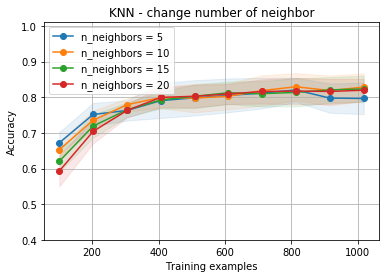

In [11]:
title = "KNN - change number of neighbor"

# duyệt qua mảng các giá trị của tham số n_neighbor 
for i, n_neighbor in enumerate([5, 10, 15, 20]):
    # Với từng giá trị n_neighbor nhận được, 
    # thực hiện build model và training cross-validate 
    # vẽ kết quả tìm được lên đồ thị đường. 
    text_clf = Pipeline([('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('clf', KNeighborsClassifier(n_neighbors=n_neighbor)),
                         ])
    
    # n_jobs = -1 để thực hiện training đa luồng song song trên tất cả các chip 
    plt = plot_learning_curve(text_clf, title, "n_neighbors = {}".format(n_neighbor),
                              data_train.data, data_train.target,
                              (0.4, 1.01),
                              train_sizes=np.linspace(.1, 1.0, 10),
                              cv=10, n_jobs=-1, idx_color=i, new_plot=i == 0)
    
# lưu hình ảnh ra file 
plt.savefig('images/knn.png', bbox_inches='tight')
plt.show()


### Thay đổi tham số C của mô hình SVM 

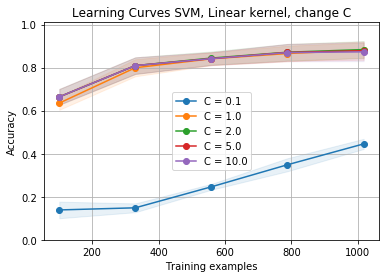

In [9]:
# model title 
title = "Learning Curves SVM, Linear kernel, change C"

# duyệt qua mảng các giá trị của tham số C 
for i, C in enumerate([.1, 1.0, 2.0, 5.0, 10.0]):
    # Với từng giá trị C nhận được, 
    # thực hiện build model và training cross-validate 
    # vẽ kết quả tìm được lên đồ thị đường. 
    text_clf = Pipeline([('vect', CountVectorizer()), # tiền xử lý dữ liệu 
                         ('tfidf', TfidfTransformer()), # tiền xử lý dữ liệu 
                         ('clf', svm.SVC(kernel='linear', C=C)), # mô hình svm với tham số C 
                         ])
    
    plt = plot_learning_curve(text_clf, title, "C = %0.1f" % (C),
                              data_train.data, data_train.target,
                              (0.0, 1.01), cv=10, n_jobs=-1, idx_color=i, new_plot=i == 0)

# lưu hình ảnh ra file 
plt.savefig('images/changeC.png', bbox_inches='tight')
plt.show()


### Thay đổi tham số criterion của mô hình Random forest  

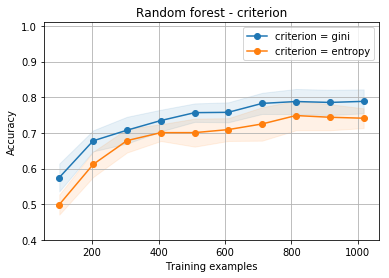

In [17]:
title = "Random forest - criterion"

# duyệt qua mảng các giá trị của tham số criterion 
for i, criterion in enumerate(["gini", "entropy"]):
    
    # Với từng giá trị criterion nhận được, 
    # thực hiện build model và training cross-validate 
    # vẽ kết quả tìm được lên đồ thị đường. 
    text_clf = Pipeline([('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('clf', RandomForestClassifier(criterion=criterion, n_estimators=50)),
                         ])
    plt = plot_learning_curve(text_clf, title, "criterion = {}".format(criterion),
                              data_train.data, data_train.target,
                              (0.4, 1.01),
                              train_sizes=np.linspace(.1, 1.0, 10),
                              cv=10, n_jobs=-1, idx_color=i, new_plot=i == 0)
# lưu hình ảnh ra file 
plt.savefig('images/RandomForestcriterion.png', bbox_inches='tight')
plt.show()


## Thay đổi số cây quyết định trong mô hình random forest 

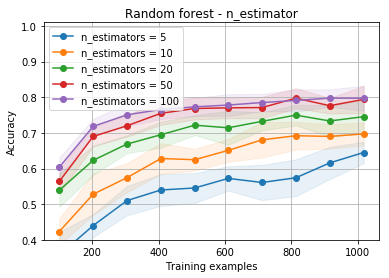

In [22]:
title = "Random forest - n_estimator"

# duyệt qua mảng các giá trị của tham số n_estimators 
for i, n_estimators in enumerate([5, 10, 20, 50, 100]):
    
    # Với từng giá trị n_estimators nhận được, 
    # thực hiện build model và training cross-validate 
    # vẽ kết quả tìm được lên đồ thị đường. 
    text_clf = Pipeline([('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('clf', RandomForestClassifier(criterion='gini', n_estimators=n_estimators)),
                         ])
    plt = plot_learning_curve(text_clf, title, "n_estimators = {}".format(n_estimators),
                              data_train.data, data_train.target,
                              (0.4, 1.01),
                              train_sizes=np.linspace(.1, 1.0, 10),
                              cv=10, n_jobs=-1, idx_color=i, new_plot=i == 0)
# lưu hình ảnh ra file 
plt.savefig('images/RandomForestN_estimator.png', bbox_inches='tight')
plt.show()

## So sánh các mô hình với các bộ tham số tốt nhất  

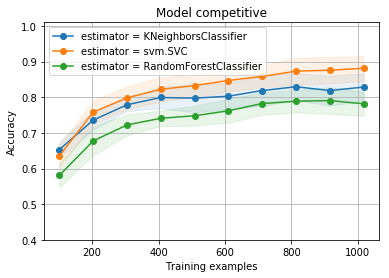

In [23]:
title = "Model competitive"

best_models = [
    KNeighborsClassifier(n_neighbors=10),
    svm.SVC(kernel='linear', C=1.0),
    RandomForestClassifier(criterion='gini', n_estimators=50)
]
best_models_name = [
    'KNeighborsClassifier',
    'svm.SVC',
    'RandomForestClassifier'
]

# duyệt qua mảng các giá trị của tham số n_estimators 
for i, estimator in enumerate(best_models):
    
    # Với từng giá trị model, 
    # thực hiện build model và training cross-validate 
    # vẽ kết quả tìm được lên đồ thị đường. 
    text_clf = Pipeline([('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('clf', estimator),
                         ])
    plt = plot_learning_curve(text_clf, title, "estimator = {}".format(best_models_name[i]),
                              data_train.data, data_train.target,
                              (0.4, 1.01),
                              train_sizes=np.linspace(.1, 1.0, 10),
                              cv=10, n_jobs=-1, idx_color=i, new_plot=i == 0)
# lưu hình ảnh ra file 
plt.savefig('images/Model_competitive.png', bbox_inches='tight')
plt.show()

## Thay đổi tiền xử lý và kiểm tra tác động 

['a_lô', 'a_ha', 'ai', 'ai_ai', 'ai_nấy', 'ai_đó', 'alô', 'amen', 'anh', 'anh_ấy']


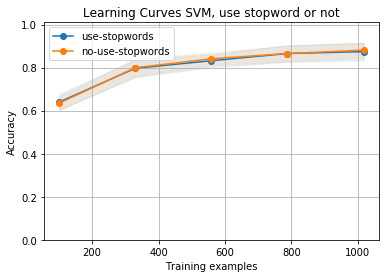

In [25]:
# load dữ liệu các stopwords 
with open("vietnamese-stopwords.txt") as f:
    stopwords = f.readlines()
stopwords = [x.strip().replace(" ", "_") for x in stopwords] 
print(stopwords[:10])

# model title 
title = "Learning Curves SVM, use stopword or not"

text_clfs = [Pipeline([('vect', CountVectorizer(stop_words=stopwords)), # tiền xử lý dữ liệu 
                         ('tfidf', TfidfTransformer()), # tiền xử lý dữ liệu 
                         ('clf', svm.SVC(kernel='linear', C=1.0)), # mô hình svm với tham số C 
                         ]), 
             Pipeline([('vect', CountVectorizer()), # tiền xử lý dữ liệu 
                         ('tfidf', TfidfTransformer()), # tiền xử lý dữ liệu 
                         ('clf', svm.SVC(kernel='linear', C=1.0)), # mô hình svm với tham số C 
                         ]), 
            ]
text_clfs_name = [
    "use-stopwords", "no-use-stopwords"
]
# duyệt qua mảng các giá trị của tham số C 
for i, text_clf in enumerate(text_clfs):
    # thực hiện build model và training cross-validate 
    # vẽ kết quả tìm được lên đồ thị đường.
    plt = plot_learning_curve(text_clf, title, "%s" % (text_clfs_name[i]),
                              data_train.data, data_train.target,
                              (0.0, 1.01), cv=10, n_jobs=-1, idx_color=i, new_plot=i == 0)

# lưu hình ảnh ra file 
plt.savefig('images/checkstopwords.png', bbox_inches='tight')
plt.show()
